In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import torch
import torch.nn as nn
import pandas as pd
from transformers import BertTokenizer, BertModel

device = torch.device("cuda")

In [ ]:
class BertLSTMClassifier(torch.nn.Module):
    def __init__(self, dropout=0.7):
        super(BertLSTMClassifier, self).__init__()

        self.bert = BertModel.from_pretrained("dbmdz/bert-base-turkish-uncased")
        self.lstm = torch.nn.LSTM(input_size=768, hidden_size=256, batch_first=True, bidirectional=True)
        self.dropout = torch.nn.Dropout(dropout)
        self.linear = torch.nn.Linear(256 * 2, 2)  # 2 çünkü Bidirectional LSTM
        self.relu = torch.nn.ReLU()

    def forward(self, input_id, mask):
        # last_hidden_state: her token için embedding (batch_size, seq_len, hidden_size)
        last_hidden_state, _ = self.bert(input_ids=input_id, attention_mask=mask, return_dict=False)

        # LSTM'e sokuyoruz tüm token vektörlerini
        lstm_output, _ = self.lstm(last_hidden_state)  # (batch_size, seq_len, 2*hidden_size)

        # Sadece ilk token ([CLS])'ın LSTM çıktısını al
        cls_lstm_output = lstm_output[:, 0, :]  # İlk token'ın çıktısı

        dropout_output = self.dropout(cls_lstm_output)
        linear_output = self.linear(dropout_output)
        final_layer = self.relu(linear_output)

        return final_layer


In [ ]:
class BertClassifier(torch.nn.Module):
  def __init__(self, dropout=0.5):
    super(BertClassifier, self).__init__()

    self.bert = BertModel.from_pretrained("dbmdz/bert-base-turkish-uncased")
    self.dropout = torch.nn.Dropout(dropout)

    # Kullandığımız önceden eğilmiş model "base" sınıfına ait bir BERT modelidir. Yani;
    # 12 layers of Transformer encoder, 12 attention heads, 768 hidden size, 110M parameters.
    # 768, BERT-base modelindeki hidden size'yi, 2 ise veri setimizdek  i toplam kategori sayısını temsil ediyor.
    self.linear = torch.nn.Linear(768, 2)
    self.relu = torch.nn.ReLU()

  def forward(self, input_id, mask):
    # _ değişkeni dizideki tüm belirteçlerin gömme vektörlerini içerir.
    # pooled_output değişkeni [CLS] belirtecinin gömme vektörünü içerir.
    # Metin sınıflandırma için polled_output değişkenini girdi olarak kullanmak yeterlidir.

    # Attention mask, bir belirtecin gercek bir kelimemi yoksa dolgu mu olduğunu tanımlar.
    # Eğer gerçek bir kelime ise attention_mask=1, eğer dolgu ise attention_mask=0 olacaktır.
    # return_dict, değeri "True ise" bir BERT modeli tahmin, eğitim veya değerlendirme sırasında ortaya çıkan
    # loss, logits, hidden_states ve attentions dan oluşan bir tuple oluşturacaktır.
    _, pooled_output = self.bert(input_ids=input_id, attention_mask=mask, return_dict=False)
    dropout_output = self.dropout(pooled_output)
    linear_output = self.linear(dropout_output)
    final_layer = self.relu(linear_output)

    return final_layer

In [ ]:
pretrained_model = BertLSTMClassifier()
pretrained_model.load_state_dict(torch.load("/content/drive/MyDrive/OFFENSIVE TEXT/BertLSTM_91AC_FINAL.pt"))

class ExtendedBertLSTMClassifier(nn.Module):
    def __init__(self, dropout=0.5):
        super().__init__()
        self.feature_extractor = pretrained_model

        # LSTM sonrası gelen 512-dim veriyi sınıflandırıcıya getir
        self.classifier = nn.Sequential(
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(512, 256),
            nn.ReLU(),

            nn.Linear(256, 128),
            nn.ReLU(),

            nn.Linear(128, 2)
        )


    def forward(self, input_ids, attention_mask):
        # Modelde parametreler donmuşsa gradient'e izin verme
        with torch.no_grad() if not any(p.requires_grad for p in self.feature_extractor.parameters()) else torch.enable_grad():
            # Feature extractor modelinin içindeki bert ve lstm katmanlarını kullan
            last_hidden = self.feature_extractor.bert(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state
            lstm_output, _ = self.feature_extractor.lstm(last_hidden)
            cls_token = lstm_output[:, 0, :]  # (batch, 512)

        return self.classifier(cls_token)




In [ ]:
from transformers import BertTokenizer
from torch.utils.data import DataLoader, Dataset
import torch

batch_size = 32
max_length = 200

tokenizer = BertTokenizer.from_pretrained("dbmdz/bert-base-turkish-uncased")

df = pd.read_csv('/content/drive/MyDrive/OFFENSIVE TEXT/preprocessed_sade_test.csv')
df = df[["text", "label"]]
df.head()

class TextDataset(torch.utils.data.Dataset):
    def __init__(self, df):
      # Kategorik sınıflar.
      self.labels = [label for label in df['labels']]
      # text = Modeli eğitmek için kullanılacak veri setindeki "clean_text" sütunundaki her bir satır.
      # padding = Her bir diziyi belirttiğimiz maksimum uzunluga kadar doldurmak için.
      # max_length = Her bir dizinin maksimum uzunluğu
      # truncation = Eğer değeri "True" ise dizimiz maksimum uzunluğu aşar ise onu keser.
      # return_tensors = Döndürelecek tensörlerin türü. Pytorch kullandığımız için "pt" yazıyoruz. Tensorflow kullansaydık "tf" yazmamız gerekirdi.
      self.text = [tokenizer(str(text), padding='max_length', max_length=max_length, truncation=True, return_tensors="pt") for text in df['text']]

    def classes(self):
      return self.labels

    def __len__(self):
      return len(self.labels)

    def get_batch_labels(self, idx):
      # Bir grup etiket getir.
      return np.array(self.labels[idx])

    def get_batch_texts(self, idx):
      # Bir grup girdi getir.
      return self.text[idx]

    def __getitem__(self, idx):
      batch_texts = self.get_batch_texts(idx)
      batch_y = self.get_batch_labels(idx)

      return batch_texts, batch_y

In [ ]:
device = torch.device("cuda")
bert_model = BertClassifier()
bert_model.load_state_dict(torch.load("/content/drive/MyDrive/OFFENSIVE TEXT/Bert_91AC_FINAL.pt"))
bert_model.eval()
bert_model.to(device)

bert_lstm_model = BertLSTMClassifier()
bert_lstm_model.load_state_dict(torch.load("/content/drive/MyDrive/OFFENSIVE TEXT/BertLSTM_91AC_FINAL.pt"))
bert_lstm_model.eval()
bert_lstm_model.to(device)

sa_model = ExtendedBertLSTMClassifier()
sa_model.load_state_dict(torch.load("/content/drive/MyDrive/OFFENSIVE TEXT/SA_NO_FREEZE_5EP_93AC.pt"))
sa_model.eval()
sa_model.to(device)

ExtendedBertLSTMClassifier(
  (feature_extractor): BertLSTMClassifier(
    (bert): BertModel(
      (embeddings): BertEmbeddings(
        (word_embeddings): Embedding(32000, 768, padding_idx=0)
        (position_embeddings): Embedding(512, 768)
        (token_type_embeddings): Embedding(2, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): BertEncoder(
        (layer): ModuleList(
          (0-11): 12 x BertLayer(
            (attention): BertAttention(
              (self): BertSdpaSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): BertSelfOutput(
                (dense): Linear(in_features=768, 

BERT Modeli Değerlendirme
Accuracy: 0.9185402779346966
F1 Score: 0.9165219404885956
ROC AUC: 0.973720164575434


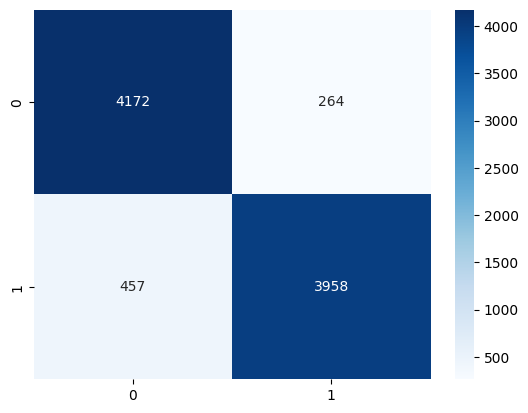

BERT+LSTM Modeli Değerlendirme
Accuracy: 0.9209128911987347
F1 Score: 0.9183578259855377
ROC AUC: 0.9702925053638153


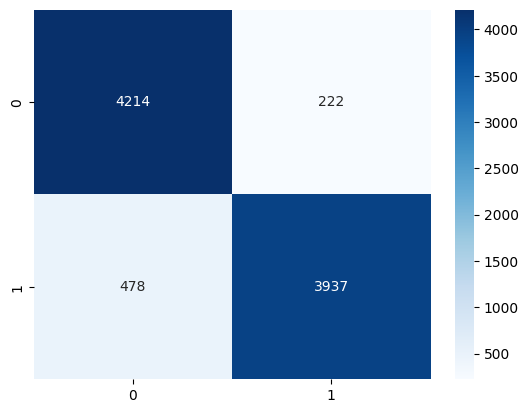

Extended Bert+LSTM Modeli Değerlendirme
Accuracy: 0.774940684668399
F1 Score: 0.8085351787773933
ROC AUC: 0.9468272049850548


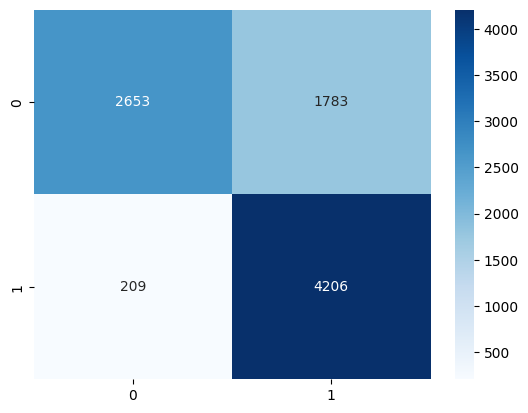

In [ ]:
device = torch.device("cuda")
def predict(model, tokenizer, texts, batch_size=8, device=device):
    model.eval()
    all_preds, all_probs = [], []
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i+batch_size]
        inputs = tokenizer(batch_texts, padding=True, truncation=True, return_tensors="pt")
        inputs = {k: v.to(device) for k, v in inputs.items()}
        with torch.no_grad():
            outputs = model(inputs['input_ids'], inputs['attention_mask'])
            probs = torch.softmax(outputs, dim=1)
            preds = torch.argmax(probs, dim=1)
        all_preds.append(preds.cpu())
        all_probs.append(probs.cpu())
    all_preds = torch.cat(all_preds)
    all_probs = torch.cat(all_probs)
    return all_preds, all_probs



texts = df["text"].tolist()

bert_preds, bert_probs = predict(bert_model, tokenizer, texts)
bert_lstm_preds, bert_lstm_probs = predict(bert_lstm_model, tokenizer, texts)
sa_preds, sa_probs = predict(sa_model, tokenizer, texts)


# Tahminlerin doğruluk, F1, ROC vs değerlendirmesi için sklearn kullanabilirsin:

from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

true_labels = df["label"].values

def evaluate(true_labels, preds, probs):
    print("Accuracy:", accuracy_score(true_labels, preds))
    print("F1 Score:", f1_score(true_labels, preds))
    try:
        print("ROC AUC:", roc_auc_score(true_labels, probs[:, 1]))
    except:
        print("ROC AUC hesaplanamadı.")
    cm = confusion_matrix(true_labels, preds)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.show()

print("BERT Modeli Değerlendirme")
evaluate(true_labels, bert_preds, bert_probs)

print("BERT+LSTM Modeli Değerlendirme")
evaluate(true_labels, bert_lstm_preds, bert_lstm_probs)

print("Extended Bert+LSTM Modeli Değerlendirme")
evaluate(true_labels, sa_preds, sa_probs)

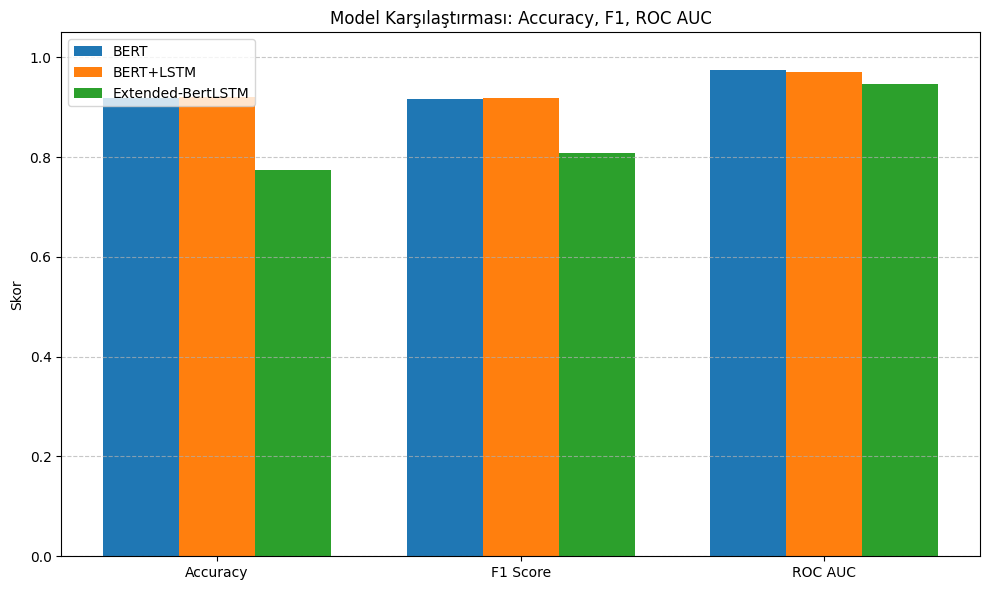

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
import matplotlib.pyplot as plt

# Skorları hesaplayan yardımcı fonksiyon
def get_metrics(true_labels, preds, probs):
    acc = accuracy_score(true_labels, preds)
    f1 = f1_score(true_labels, preds)
    try:
        roc = roc_auc_score(true_labels, probs[:, 1])
    except:
        roc = 0.0
    return acc, f1, roc

# Her modelin skorlarını al
bert_scores = get_metrics(true_labels, bert_preds, bert_probs)
bert_lstm_scores = get_metrics(true_labels, bert_lstm_preds, bert_lstm_probs)
sa_scores = get_metrics(true_labels, sa_preds, sa_probs)

# Bar chart çizimi
labels = ["Accuracy", "F1 Score", "ROC AUC"]
x = range(len(labels))
width = 0.25

plt.figure(figsize=(10,6))
plt.bar([i - width for i in x], bert_scores, width=width, label="BERT")
plt.bar(x, bert_lstm_scores, width=width, label="BERT+LSTM")
plt.bar([i + width for i in x], sa_scores, width=width, label="Extended-BertLSTM")

plt.xticks(x, labels)
plt.ylabel("Skor")
plt.ylim(0, 1.05)
plt.title("Model Karşılaştırması: Accuracy, F1, ROC AUC")
plt.legend()
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.metrics import classification_report

print("🟦 BERT Modeli - Classification Report:")
print(classification_report(true_labels, bert_preds, target_names=["Toxic", "Non-Toxic"]))

print("\n🟧 BERT+LSTM Modeli - Classification Report:")
print(classification_report(true_labels, bert_lstm_preds, target_names=["Toxic", "Non-Toxic"]))

print("\n🟥 SA (Extenden BertLSTM Model) Modeli - Classification Report:")
print(classification_report(true_labels, sa_preds, target_names=["Toxic", "Non-Toxic"]))


🟦 BERT Modeli - Classification Report:
              precision    recall  f1-score   support

       Toxic       0.90      0.94      0.92      4436
   Non-Toxic       0.94      0.90      0.92      4415

    accuracy                           0.92      8851
   macro avg       0.92      0.92      0.92      8851
weighted avg       0.92      0.92      0.92      8851


🟧 BERT+LSTM Modeli - Classification Report:
              precision    recall  f1-score   support

       Toxic       0.90      0.95      0.92      4436
   Non-Toxic       0.95      0.89      0.92      4415

    accuracy                           0.92      8851
   macro avg       0.92      0.92      0.92      8851
weighted avg       0.92      0.92      0.92      8851


🟥 SA (Extenden BertLSTM Model) Modeli - Classification Report:
              precision    recall  f1-score   support

       Toxic       0.93      0.60      0.73      4436
   Non-Toxic       0.70      0.95      0.81      4415

    accuracy                      